# Model Description: **Crop Yield Predictor**

- A model that predicts a crop's year based on various factors

- Dataset features:
  - Region : Categorical feature
  - Soil Type	 : Categorical feature
  - Crop : Categorical feature
  - Rainfall (mm)	: Numerical feature
  - Temperature Celsius	: Numerical feature
  - Fertilizer Used	: Categorical feature
  - Irrigation Used	: Categorical feature
  - Weather Condition	: Categorical feature
  - Days to Harvest	: Numerical feature

- Dataset label:
  - Yield ons per hectare : Continuous label





Ignore Warnings

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Library use

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
#Mount google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# #set the path
# data_path = "/content/drive/MyDrive/Crop_Yield_Predictor_Project/crop_yield.csv"

#path for local run
data_path = "crop_yield.csv"

Mounted at /content/drive


# 1 - Loaded Dataset

In [ ]:
# crop_data = pd.read_csv("crop_yield.csv")
crop_data = pd.read_csv(data_path)
crop_data.head()

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


In [ ]:
print(crop_data.shape)

(1000000, 10)


# 2 - Data cleaning and analyzing

In [8]:
#dataset statistic
crop_data.describe()

,Rainfall_mm,Temperature_Celsius,Days_to_Harvest,Yield_tons_per_hectare
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,549.981901,27.504965,104.495025,4.649472
std,259.851320,7.220608,25.953412,1.696572
min,100.000896,15.000034,60.000000,-1.147613
25%,324.891090,21.254502,82.000000,3.417637
50%,550.124061,27.507365,104.000000,4.651808
75%,774.738520,33.753267,127.000000,5.879200
max,999.998098,39.999997,149.000000,9.963372


=> Range of the label Yield_tons_per_hectare: 9.9 - (-1,1) ~ 11.1

Distribution of Numerical Features

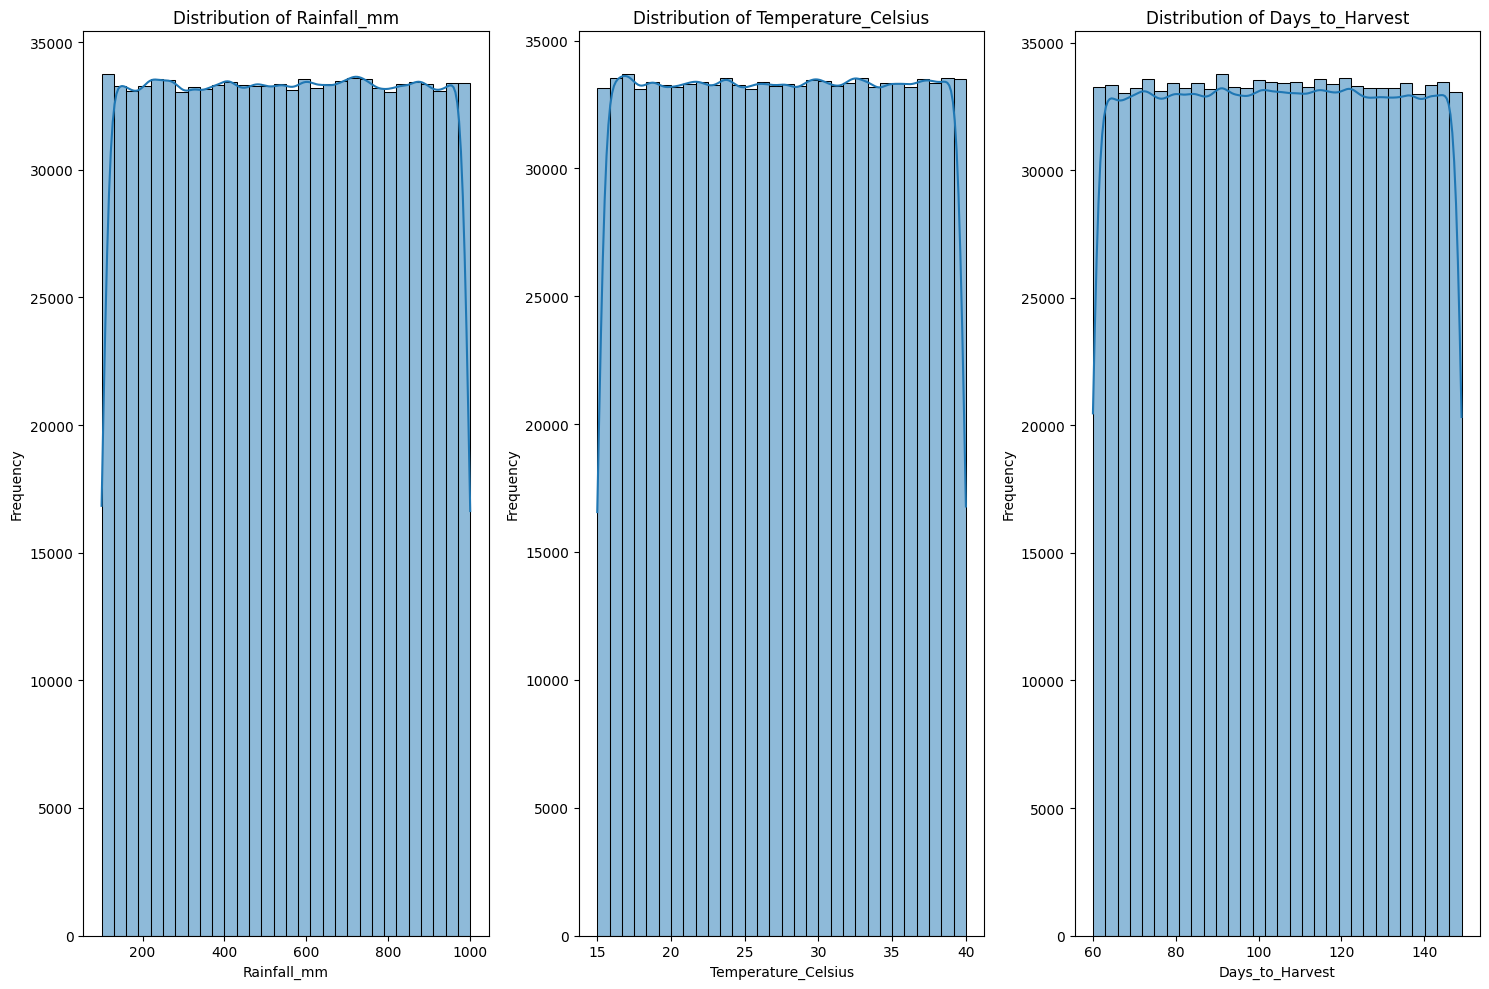

In [14]:
numerical_cols = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']

#create subplots for each numerical column
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(crop_data[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Distribution of the categorical columns

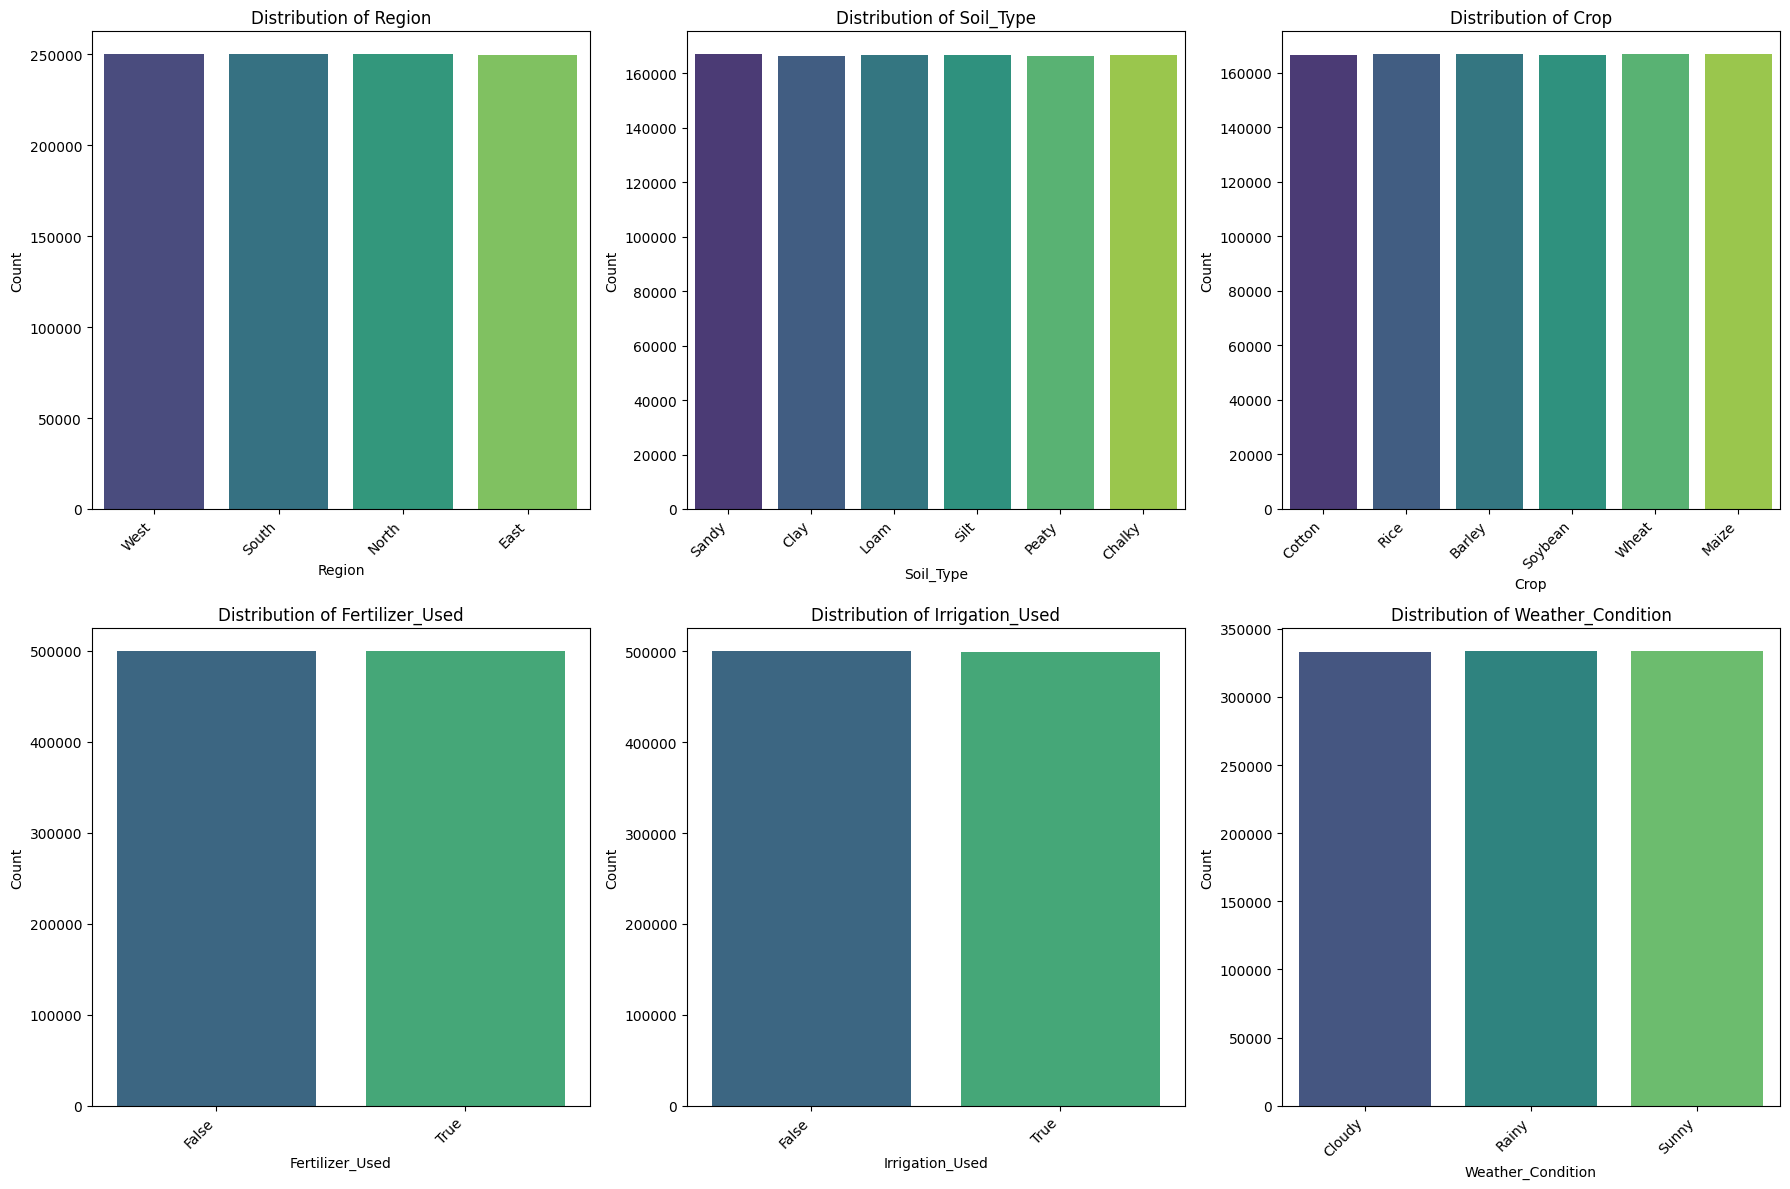

In [17]:
cate_feat = ["Region", "Soil_Type", "Crop",  "Fertilizer_Used", "Irrigation_Used", "Weather_Condition"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(cate_feat):
    sns.countplot(
        data=crop_data,
        x=col,
        hue=col,
        legend=False,
        ax=axes[i],
        palette='viridis'
    )

    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

    # Rotate + align labels properly
    axes[i].tick_params(axis='x', labelrotation=45)
    for tick in axes[i].get_xticklabels():
        tick.set_ha('right')

plt.tight_layout()
plt.show()


In [ ]:
#Check missing values
print(crop_data.isnull().sum())

Region                    0
Soil_Type                 0
Crop                      0
Rainfall_mm               0
Temperature_Celsius       0
Fertilizer_Used           0
Irrigation_Used           0
Weather_Condition         0
Days_to_Harvest           0
Yield_tons_per_hectare    0
dtype: int64


=> this dataset doesn't need to be cleaned

# 3 - Scale data if needed:
In this project, I decided not to scale the numerical features. The reason is because the model I am using does not strictly require feature scaling for good performance. The numerical values in the dataset (Rainfall, Temperature, Days to Harvest, and Yield) are already in reasonable ranges, and they do not cause instability or affect the learning process of the model.


Since the goal of this project is to analyze the relationship between the features and the final crop yield, keeping the values in their original units actually makes the results easier to interpret. For example, rainfall measured in millimeters or temperature in Celsius is more meaningful when kept in the original scale.


Overall, scaling was not necessary for this dataset, and skipping it helps keep the data more natural and easier to understand in the analysis stage.

# 4 - Encode the categorical features
Because the feature dataset include the categorical and numerical, we need to encode the categorical data

In [25]:
crop_data2 = crop_data.copy() #this is the data after encoding the categorical features

cate_feat = ["Region", "Soil_Type", "Crop",  "Fertilizer_Used", "Irrigation_Used", "Weather_Condition"]

from sklearn.preprocessing import LabelEncoder

#Keep the encoders so you can check mapping later
encoders = {}

for i in cate_feat:
  labels = LabelEncoder()
  crop_data2[i] = labels.fit_transform(crop_data2[i])
  encoders[i] = labels

crop_data2.head()

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,3,4,1,897.077239,27.676966,0,1,0,122,6.555816
1,2,1,3,992.673282,18.026142,1,1,1,140,8.527341
2,1,2,0,147.998025,29.794042,0,0,2,106,1.127443
3,1,4,4,986.866331,16.644190,0,1,1,146,6.517573
4,2,5,5,730.379174,31.620687,1,1,0,110,7.248251


Map of encoding

In [26]:
for col, le in encoders.items():
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"Mapping for {col}:")
    print(mapping)
    print()

Mapping for Region:
{'East': np.int64(0), 'North': np.int64(1), 'South': np.int64(2), 'West': np.int64(3)}

Mapping for Soil_Type:
{'Chalky': np.int64(0), 'Clay': np.int64(1), 'Loam': np.int64(2), 'Peaty': np.int64(3), 'Sandy': np.int64(4), 'Silt': np.int64(5)}

Mapping for Crop:
{'Barley': np.int64(0), 'Cotton': np.int64(1), 'Maize': np.int64(2), 'Rice': np.int64(3), 'Soybean': np.int64(4), 'Wheat': np.int64(5)}

Mapping for Fertilizer_Used:
{np.False_: np.int64(0), np.True_: np.int64(1)}

Mapping for Irrigation_Used:
{np.False_: np.int64(0), np.True_: np.int64(1)}

Mapping for Weather_Condition:
{'Cloudy': np.int64(0), 'Rainy': np.int64(1), 'Sunny': np.int64(2)}



Counts for Each Encoded Categorical Feature

In [27]:
for col in cate_feat:
    print(f"Value counts for encoded {col}:")
    display(crop_data[col].value_counts().sort_index())
    print('\n')

Value counts for encoded Region:


,count
Region,
East,249699
North,250173
South,250054
West,250074




Value counts for encoded Soil_Type:


,count
Soil_Type,
Chalky,166779
Clay,166352
Loam,166795
Peaty,166283
Sandy,167119
Silt,166672




Value counts for encoded Crop:


,count
Crop,
Barley,166777
Cotton,166585
Maize,166824
Rice,166792
Soybean,166349
Wheat,166673




Value counts for encoded Fertilizer_Used:


,count
Fertilizer_Used,
False,500060
True,499940




Value counts for encoded Irrigation_Used:


,count
Irrigation_Used,
False,500509
True,499491




Value counts for encoded Weather_Condition:


,count
Weather_Condition,
Cloudy,332649
Rainy,333561
Sunny,333790


# 5 - Splitting the Dataset into X_data and y_data and train/validate/test sets

Split feature set and label set

In [28]:
#feature columns
X_data = crop_data2.iloc[:, :-1]
#label columns
y_data = crop_data2.iloc[:,-1]

#check for it shape
print(X_data.shape)
print(y_data.shape)

(1000000, 9)
(1000000,)


Splitting the Dataset into training and testing sets

In [29]:
from sklearn.model_selection import train_test_split

#split the train and test set in ratio 7:3
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

#split the validata and test set in ratio 5:5 => we will have train:validate:test = 7:1.5:1.5
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(700000, 9)
(150000, 9)
(150000, 9)


# 6 - Define the model

In [30]:
#define the model
model = LGBMRegressor(
    objective='regression',        #for continuous target (Yield per hectare)
    num_leaves=50,                 #max number of leaves in one tree (tree complexity)
    max_depth=20,                  #max tree depth to reduce overfitting
    learning_rate=0.01,             #step size for boosting
    n_estimators=5000,             #number iteration
    min_child_samples=20,          #minimum samples in a leaf
    verbose=1000,
    random_state=42                #ensures reproducibility
)

# 7 - Train/validate the model

In [31]:
#start the train
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)], #validate set
    eval_metric='rmse', #Root Mean Squared Error
    categorical_feature=cate_feat, #list of categorical features
)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with 

LGBMRegressor(learning_rate=0.01, max_depth=20, n_estimators=5000,
              num_leaves=50, objective='regression', random_state=42,
              verbose=1000)

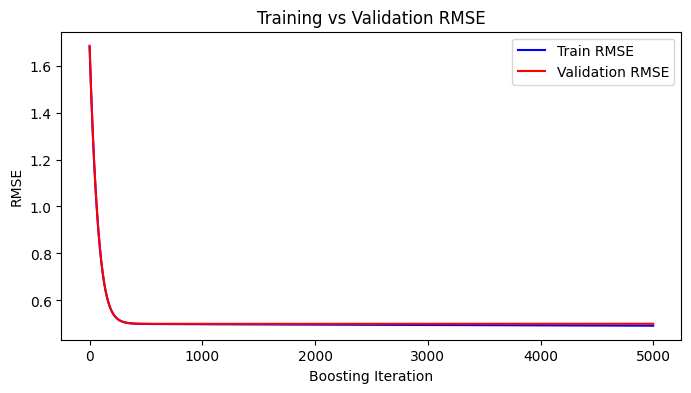

In [32]:
#get the records for the metric values
evals_result = model.evals_result_

import matplotlib.pyplot as plt

#extract RMSE values
train_rmse = evals_result['training']['rmse']
val_rmse = evals_result['valid_1']['rmse']


# Plot both curves in the same figure
plt.figure(figsize=(8,4))
plt.plot(train_rmse, label='Train RMSE', color='blue')
plt.plot(val_rmse, label='Validation RMSE', color='red')

# Titles and labels
plt.title('Training vs Validation RMSE')
plt.xlabel('Boosting Iteration')
plt.ylabel('RMSE')
plt.legend()  # Show legend

plt.show()

# 8 - Apply the model on the test set and evaluate the metrics scores

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#predict on test set
y_pred = model.predict(X_test)

#Evaluate some metrics value for this model

#Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

#Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

#Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

#R-squared (R2)
r2 = r2_score(y_test, y_pred)

#Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print results
print("----- Test Set Evaluation Metrics -----")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"R²   : {r2:.3f}")
print(f"MAPE : {mape:.2f}%")


----- Test Set Evaluation Metrics -----
MSE  : 0.253
RMSE : 0.503
MAE  : 0.401
R²   : 0.912
MAPE : 12.06%


## Analyze the predict result


RMSE = 0.503 → average prediction error is 0.5 tons/ha

MAE = 0.401 → average absolute error is 0.4 tons/ha

MAPE = 12% → relative error is ~12% of actual values


***Interpretation***

RANGE OF THE LABEL: Max label - min label ~ 11.1 (need to be update after we clean the data since the current data havent cleaned yet)

1. Absolute error vs range

- RMSE / range ~ 0.503 / 11.1 ≈ 4.5% of full range

- MAE / range ~ 0.401 / 11.1 ≈ 3.6% of full range

  => These are small relative errors, meaning predictions are quite close to actual yield values.

2. R² = 0.912 : Means it explains 91% of variance, which is excellent.

3. Consistency

- Since RMSE > MAE, some larger errors exist, but overall error is small.

***Conclusion***

- Model is strong: high R², low RMSE/MAE relative to the target range.

- Errors are small compared to the overall yield variation.

# 9 - Save the model into the pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
import joblib

preprocessor = ColumnTransformer(
    transformers=[('cat', OrdinalEncoder(), cate_feat)],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', model)
])


#Fit the pipeline
pipeline.fit(X_train, y_train)

# Save pipeline
# Save to website directory so Flask app can use it
save_path = 'crop_yield_pipeline.pkl'

joblib.dump(pipeline, save_path)
print("Pipeline with encoding saved successfully in path "+save_path)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 6
[LightGBM] [Debug] Trained a tree with 

# 10 - Apply the pipeline into the new data

In [35]:
data_point_x = {
    "Region": 'North',
    "Soil_Type": 'Loam',
    "Crop": 'Barley',
    "Rainfall_mm": 144,
    "Temperature_Celsius": 32,
    "Fertilizer_Used": 'False',
    "Irrigation_Used": 'False',
    "Weather_Condition": 'Rainy',
    "Days_to_Harvest": 106
}
true_x = pd.DataFrame([data_point_x])

#Encode manually using saved encoders
for col in cate_feat:
    true_x[col] = encoders[col].transform(true_x[col])
true_x = true_x[X_train.columns]  # reorder columns


#Load pipeline
pipeline_loaded = joblib.load(save_path)

#Predict
y_pred = pipeline_loaded.predict(true_x)

print("Predicted yield per hectare:", y_pred[0])


Predicted yield per hectare: 4.053948978712706


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
